<a href="https://www.kaggle.com/code/andersonacavalcante/enade-2021?scriptVersionId=108003522" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Montando o ambiente** 

Adicionando todas as bibliotecas que vão ser usadas para manipular os dados:

O código está baseado nesses desenvolvimentos:

* [https://www.kaggle.com/code/joaoavf/analise-enade/notebook](https://www.kaggle.com/code/joaoavf/analise-enade/notebook)

* [https://github.com/daarfarias/Analise-Exploratoria-ENADE-2019---Python/blob/main/An%C3%A1lise%20Explorat%C3%B3ria%20ENADE%202019%20-%20Python.ipynb](http://)

In [1]:
# Biblotecas de manipulação de dados
import numpy as np
import pandas as pd
import glob

# Bibliotecas de visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Testes estatísticos
from scipy.stats import ttest_ind

# **Carregando arquivos do ENADE 2021**

In [2]:
#lista_arquivos = pd.read_excel("../input/microdados-enade-2021-lgpd/microdados_Enade_2021_LGPD/1.LEIA-ME/Dicionrio_arquivos_variveis_microdados_Enade_2021.xlsx",sheet_name = "DICIONÁRIO_ARQUIVOS",usecols ="A" )
#%display(lista_arquivos)

In [3]:
folder_path = '../input/microdados-enade-2021-lgpd/microdados_Enade_2021_LGPD/2.DADOS'
file_list = glob.glob(folder_path + "/*.txt")
df_2021 = pd.DataFrame(pd.read_table(file_list[0],delimiter = ";",header = 0, low_memory=False))

for i in range(1,len(file_list)):
    data = pd.read_table(file_list[i],delimiter = ";",header = 0, low_memory=False)
    df = pd.DataFrame(data)
    df_2021 = pd.concat([df_2021,df],axis=1)
print(df_2021)

        NU_ANO  CO_CURSO TP_SEXO  NU_ANO  CO_CURSO QE_I08  NU_ANO  CO_CURSO  \
0         2021     45498       F    2021     63045      A    2021     14346   
1         2021    116120       F    2021     45498      A    2021     18312   
2         2021   1514190       F    2021    116120      A    2021     14349   
3         2021   1438321       F    2021   1514190      A    2021    123778   
4         2021   1137369       F    2021    123778      A    2021   1438321   
...        ...       ...     ...     ...       ...    ...     ...       ...   
489861    2021      6102     NaN    2021     70985    NaN    2021     70985   
489862    2021   1425255     NaN    2021     70985    NaN    2021     70985   
489863    2021   1520497     NaN    2021     70985    NaN    2021     70985   
489864    2021     81230     NaN    2021     70985    NaN    2021     70985   
489865    2021    108230     NaN    2021     70985    NaN    2021     70985   

       QE_I21  NU_ANO  ...  QE_I10  NU_ANO  CO_CURS

In [4]:
df_2021['DS_VT_ACE_OFG'] = df_2021['DS_VT_ACE_OFG'].astype(str)
df_2021['DS_VT_ACE_OCE'] = df_2021['DS_VT_ACE_OCE'].astype(str)

In [5]:
# show the datatypes
print(df_2021['DS_VT_ACE_OFG'].dtypes)
print(df_2021['DS_VT_ACE_OCE'].dtypes)

object
object


# **Verificando tamanho do arquivo:**

In [6]:
df_2021.shape

(489866, 241)

# **Salvando o arquivo final**

In [7]:
df_2021.to_csv('dados_enade_2021.csv', index=False)

# **Carregando Dicionário de Dados**

In [8]:
data_dict_path_2021 = '../input/microdados-enade-2021-lgpd/microdados_Enade_2021_LGPD/1.LEIA-ME/Dicionrio_arquivos_variveis_microdados_Enade_2021.xlsx'


In [9]:
data_dict_2021 = pd.read_excel(data_dict_path_2021,sheet_name = 'DICIONÁRIO DE VARIÁVEIS',header=1)
data_dict_2021['NOME'] = data_dict_2021['NOME'].fillna(method='ffill')
print (data_dict_2021)

                                                  NOME TIPO  TAMANHO  \
0                                               NU_ANO    N      4.0   
1    INFORMAÇÕES DA INSTITUIÇÃO DE ENSINO SUPERIOR ...  NaN      NaN   
2                                               CO_IES    N      5.0   
3                                           CO_CATEGAD    N      1.0   
4                                           CO_CATEGAD  NaN      NaN   
..                                                 ...  ...      ...   
993                                             QE_I92  NaN      NaN   
994                                             QE_I92  NaN      NaN   
995                                             QE_I92  NaN      NaN   
996                                             QE_I92  NaN      NaN   
997                                             QE_I92  NaN      NaN   

                                     DESCRIÇÃO                  CATEGORIAS  \
0                   Ano de realização do exame           

/opt/conda/lib/python3.7/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


# Salvando o Dicionário em formato .csv

In [10]:
data_dict_2021.to_csv('data_dict_2021.csv', index=False)

In [11]:
data_dict_2021.shape

(998, 6)

# Criando um mapa de perguntas e a descrição correspondente:

In [12]:
mapa_pg = pd.read_excel(data_dict_path_2021,sheet_name = 'DICIONÁRIO DE VARIÁVEIS',header = 1)[['NOME', 'DESCRIÇÃO']].dropna().set_index('NOME').to_dict()['DESCRIÇÃO']

/opt/conda/lib/python3.7/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


# **Criando funções auxiliares**

Preparando função para mapear as respostas do ENADE para o valor correspondente (ligar o código do curso ao nome do curso, por exemplo):

In [13]:
def mapear_coluna(df, data_dict, coluna):
    if coluna == 'CO_CATEGAD':
        tmp = data_dict.query("NOME == @coluna")['CATEGORIAS'].str.split('.', expand=True).dropna()
        if tmp.shape[1] <= 1: #work-around for NU_IDADE
            return {i:i for i in sorted(df[coluna].unique())}
    else:
        tmp = data_dict.query("NOME == @coluna")['CATEGORIAS'].str.split('=', expand=True).dropna()
        if tmp.shape[1] <= 1: #work-around for NU_IDADE
            return {i:i for i in sorted(df[coluna].unique())}
        
    tmp.iloc[:, 0] = tmp.iloc[:, 0].str.strip().astype(df[coluna].dtype)
    tmp.iloc[:, 1] = tmp.iloc[:, 1].str.strip().str.upper()
    return tmp.set_index(0).iloc[:,0].to_dict()

Testando a função de mapear coluna com a pergunta QE_I08, que é sobre renda familiar:

In [14]:
mapear_coluna(df_2021, data_dict_2021, 'QE_I08')

{'A': 'ATÉ 1,5 SALÁRIO MÍNIMO (ATÉ R$ 1.650,00).',
 'B': 'DE 1,5 A 3 SALÁRIOS MÍNIMOS (R$ 1.650,01 A R$ 3.300,00).',
 'C': 'DE 3 A 4,5 SALÁRIOS MÍNIMOS (R$ 3.300,01 A R$ 4.950,00).',
 'D': 'DE 4,5 A 6 SALÁRIOS MÍNIMOS (R$ 4.950,01 A R$ 6.600,00).',
 'E': 'DE 6 A 10 SALÁRIOS MÍNIMOS (R$ 6.600,01 A R$ 11.000,00).',
 'F': 'DE 10 A 30 SALÁRIOS MÍNIMOS (R$ 11.000,01 A R$ 33.000,00).',
 'G': 'ACIMA DE 30 SALÁRIOS MÍNIMOS (MAIS DE R$ 33.000,00).'}

In [15]:
mapear_coluna(df_2021, data_dict_2021, 'QE_I09')

{'A': 'NÃO TENHO RENDA E MEUS GASTOS SÃO FINANCIADOS POR PROGRAMAS GOVERNAMENTAIS.',
 'B': 'NÃO TENHO RENDA E MEUS GASTOS SÃO FINANCIADOS PELA MINHA FAMÍLIA OU POR OUTRAS PESSOAS.',
 'C': 'TENHO RENDA, MAS RECEBO AJUDA DA FAMÍLIA OU DE OUTRAS PESSOAS PARA FINANCIAR MEUS GASTOS.',
 'D': 'TENHO RENDA E NÃO PRECISO DE AJUDA PARA FINANCIAR MEUS GASTOS.',
 'E': 'TENHO RENDA E CONTRIBUO COM O SUSTENTO DA FAMÍLIA.',
 'F': 'SOU O PRINCIPAL RESPONSÁVEL PELO SUSTENTO DA FAMÍLIA.'}

Substituindo o mapeamento do Campo CO_REGIÃO_CURSO que está com padrão diferente no dicionário de Variáveis:

In [16]:
df_2021["CO_REGIAO_CURSO"]= df_2021["CO_REGIAO_CURSO"].map({1:"Região Norte",2:"Região Nordeste",3:"Região Sudeste",4:"Região Sul",5:"Região Centro-Oeste"})

In [17]:
df_2021['CO_REGIAO_CURSO']

0         Região Centro-Oeste
1         Região Centro-Oeste
2         Região Centro-Oeste
3         Região Centro-Oeste
4         Região Centro-Oeste
                 ...         
489861        Região Nordeste
489862        Região Nordeste
489863        Região Nordeste
489864        Região Nordeste
489865             Região Sul
Name: CO_REGIAO_CURSO, Length: 489866, dtype: object

In [18]:
#df_2021["CO_UF_CURSO"] = df_2021["CO_UF_CURSO"].map(mapear_coluna(df_2021, data_dict_2021, 'CO_UF_CURSO'))

Verificando a quantidade de respostas para cada questão da coluna com a pergunta QE_I08, que é sobre renda familiar:

**Buscando padrões de preenchimento no questionário socioeconômico:
Vamos primeiro selecionar as colunas que nos interessam (QE_I01 a QE_I26), que são as referentes ao questionário socioeconômico:**

In [19]:
questionario_colunas = [c for c in df_2021.columns if 'QE_I' in c]
socioeconomico_colunas = [c for c in questionario_colunas if int(c[-2:]) < 27]

Vamos olhar os valores possíveis de preenchimento:

In [20]:
df_2021[socioeconomico_colunas].apply(pd.Series.value_counts).T

,11.0,12.0,13.0,14.0,15.0,16.0,17.0,21.0,22.0,23.0,...,B,C,D,E,F,G,H,I,J,K
QE_I08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,145965.0,64285.0,36710.0,29167.0,12200.0,1224.0,NaN,NaN,NaN,NaN
QE_I21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,151205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QE_I23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,188802.0,119991.0,45401.0,32454.0,NaN,NaN,NaN,NaN,NaN,NaN
QE_I13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25692.0,14018.0,9455.0,2452.0,40646.0,NaN,NaN,NaN,NaN,NaN
QE_I09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87602.0,95743.0,53573.0,106830.0,43216.0,NaN,NaN,NaN,NaN,NaN
QE_I16,3803.0,2359.0,6500.0,1293.0,17791.0,2029.0,2984.0,11477.0,6856.0,14382.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QE_I25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27163.0,44697.0,3089.0,148751.0,14444.0,6200.0,72128.0,NaN,NaN,NaN
QE_I15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11227.0,21356.0,31883.0,20217.0,7616.0,NaN,NaN,NaN,NaN,NaN
QE_I19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,209219.0,51249.0,18932.0,1914.0,29001.0,17879.0,NaN,NaN,NaN,NaN
QE_I18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31516.0,23706.0,34004.0,5662.0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
socioeconomico_colunas = [c for c in socioeconomico_colunas if c not in ['QE_I16']]

In [22]:
resp_dict = {}
df_2021['QE_RESPOSTAS_IGUAIS'] = False
for resp in ['A', 'B']:
    
    df_2021['QE_RESPOSTAS_IGUAIS'] = df_2021['QE_RESPOSTAS_IGUAIS'] | ((df_2021[socioeconomico_colunas] == resp).mean(axis=1) == 1)

    resp_dict[resp]= ((df_2021[socioeconomico_colunas] == resp).mean(axis=1) == 1).sum()

In [23]:
resp_dict

{'A': 22019, 'B': 0}

Interessante ver que tivemos preenchimento repetido seguindo apenas a letra A. Nesse caso é extremamente difícil discernir o que são respostas válidas e o que não são, ainda mais quando se leva em conta que existe algum erro presente no preenchimento do questionário.

Fazendo mais uma verificação de consistência, seguindo uma lógica similar ao que fizemos quando buscamos analisar desvios no preenchimento das provas, conseguimos ver que as notas nas provas são similares entre os dois grupos.

Por esse motivo a decisão é de novamente deixar os dados como estão, sem remover linhas.

# Criando função para agrupar valores segundo uma variável e nos retornar uma métrica chave agregada:

In [24]:
def groupby_1_var(df, groupby_var, key_var, agg_method=['mean', 'std', 'count']):
    tmp = df.groupby(groupby_var)[key_var].agg(agg_method).sort_index()
    tmp.index = pd.Series(tmp.index).replace(mapear_coluna(df_2021, data_dict_2021, groupby_var))
    tmp.index.name = mapa_pg[tmp.index.name]
    return tmp

Criando a função para agrupar valores segundo duas variáveis e nos retornar uma métrica chave agregada:

In [25]:
def groupby_2_var(df, var1, var2, key_var, agg_method=['mean'], index_line=False, percentualize=False):
    tmp = df.groupby([var1, var2])[key_var].agg(agg_method).unstack()
    if percentualize:
        tmp = tmp.div(tmp.sum(axis=1), axis=0)
    if index_line:
        tmp = tmp.div(tmp.iloc[0])
        
    tmp.index = pd.Series(tmp.index).replace(mapear_coluna(df_2021, data_dict_2021, var1))
    tmp.index.name = mapa_pg[tmp.index.name]
    
    tmp.columns = tmp.columns.droplevel(0)
    tmp.columns = pd.Series(tmp.columns).replace(mapear_coluna(df_2021, data_dict_2021, var2))
    tmp.columns.name = mapa_pg[tmp.columns.name]
    
    return tmp

Criando função para avaliar significância estatística de grupos separados por uma variável var dada uma métrica key_var:

In [26]:
def stat_sig(df, var, key_var):
    lista_de_listas = []
    valores = sorted(df[var].dropna().unique().tolist())
    for i in valores:
        lista_de_listas.append([])
        for j in valores:
            t_res = ttest_ind(df.query(f'{var} == @i')[key_var], df.query(f'{var} == @j')[key_var])
            lista_de_listas[-1].append(t_res.pvalue)
            
    
    valores = pd.Series(valores).replace(mapear_coluna(df_2021, data_dict_2021, var))
    tmp = pd.DataFrame(lista_de_listas, index=valores, columns=valores)    
   
    return tmp

# Verificando qualidade dos dados da variável NT_GER:

A variável que iremos utilizar nesta etapa se chama NT_GER e corresponde a nota geral. Vamos verificar se ela contém valores vazios:

In [27]:
df_2021['NT_GER'].isnull().mean()

0.27551820293712975

Temos 27,55% dos valores vazios na coluna de nota geral (NT_GER).

Em uma prova padronizada como essa, não ter uma nota está associado a uma nota zero. Por essa razão vamos preencher os valores nulos com 0:

In [28]:
df_2021['NT_GER'].fillna(0,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


# Renda Familiar vs nota

A tabela abaixo traz média (mean), desvio padrão (std) e contagem (count) da variável de nota geral NT_GER por grupos de faixas de renda (QE_I08 - questão 8 do questionário socioeconômico):

In [29]:
groupby_1_var(df=df_2021, groupby_var='QE_I08', key_var = 'NT_GER')

,mean,std,count
"Qual a renda total de sua família, incluindo seus rendimentos?",,,
"ATÉ 1,5 SALÁRIO MÍNIMO (ATÉ R$ 1.650,00).",22.871785,5.430344,119435
"DE 1,5 A 3 SALÁRIOS MÍNIMOS (R$ 1.650,01 A R$ 3.300,00).",38.501702,4.877332,145965
"DE 3 A 4,5 SALÁRIOS MÍNIMOS (R$ 3.300,01 A R$ 4.950,00).",53.512779,3.821313,64285
"DE 4,5 A 6 SALÁRIOS MÍNIMOS (R$ 4.950,01 A R$ 6.600,00).",67.477489,5.115124,25214
"DE 6 A 10 SALÁRIOS MÍNIMOS (R$ 6.600,01 A R$ 11.000,00).",NaN,NaN,0
"DE 10 A 30 SALÁRIOS MÍNIMOS (R$ 11.000,01 A R$ 33.000,00).",NaN,NaN,0
"ACIMA DE 30 SALÁRIOS MÍNIMOS (MAIS DE R$ 33.000,00).",NaN,NaN,0


# Horas de Estudo por Semana vs Nota

A tabela abaixo a traz nota geral NT_GER por grupos de horas de estudo por semana (QE_I23 - questão 23 do questionário socioeconômico):

In [30]:
groupby_1_var(df=df_2021, groupby_var='QE_I23', key_var = 'NT_GER')

,mean,std,count
"Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?",,,
"NENHUMA, APENAS ASSISTO ÀS AULAS.",14.128671,3.375040,22329
DE UMA A TRÊS.,29.953133,6.115389,188802
DE QUATRO A SETE.,49.246552,5.857188,119991
DE OITO A DOZE.,67.847302,5.034370,23777
MAIS DE DOZE.,NaN,NaN,0


# Renda e Horas de Estudo vs Nota

Vamos agrupar agora por renda e horas de estudo e observar como a nota média se comporta de acordo com essas variações:

In [31]:
groupby_2_var(df_2021, var1='QE_I08', var2='QE_I23', key_var = 'NT_GER')


"Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?","NENHUMA, APENAS ASSISTO ÀS AULAS.",DE UMA A TRÊS.,DE QUATRO A SETE.,DE OITO A DOZE.,MAIS DE DOZE.
"Qual a renda total de sua família, incluindo seus rendimentos?",,,,,
"ATÉ 1,5 SALÁRIO MÍNIMO (ATÉ R$ 1.650,00).",14.128671,24.882216,NaN,NaN,NaN
"DE 1,5 A 3 SALÁRIOS MÍNIMOS (R$ 1.650,01 A R$ 3.300,00).",NaN,35.323231,43.872227,NaN,NaN
"DE 3 A 4,5 SALÁRIOS MÍNIMOS (R$ 3.300,01 A R$ 4.950,00).",NaN,NaN,53.512779,NaN,NaN
"DE 4,5 A 6 SALÁRIOS MÍNIMOS (R$ 4.950,01 A R$ 6.600,00).",NaN,NaN,61.358455,67.847302,NaN
"DE 6 A 10 SALÁRIOS MÍNIMOS (R$ 6.600,01 A R$ 11.000,00).",NaN,NaN,NaN,NaN,NaN
"DE 10 A 30 SALÁRIOS MÍNIMOS (R$ 11.000,01 A R$ 33.000,00).",NaN,NaN,NaN,NaN,NaN
"ACIMA DE 30 SALÁRIOS MÍNIMOS (MAIS DE R$ 33.000,00).",NaN,NaN,NaN,NaN,NaN


# Diferenças entre Tipos de Nota

Os dados do ENADE nos trazem 5 tipos de notas compiladas:

NT_GER - Nota geral do ENADE
NT_OBJ_FG - Nota da prova objetiva de formação geral
NT_DIS_FG - Nota da prova discursiva de formação geral
NT_OBJ_CE - Nota da prova objetiva de conhecimento específico
NT_DIS_CE - Nota da prova discursiva de conhecimento específico
Abaixo vamos criar uma lista que contenha todos os identificadores de cada uma das notas acima:

In [32]:
tipos_de_nota = ['NT_GER', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_OBJ_CE', 'NT_DIS_CE']

# Tipos de Nota vs Variações de Renda

Vamos olhar como cada um dos tipos de nota se comporta com variações de renda:

In [33]:
notas_por_renda = groupby_1_var(df=df_2021, groupby_var='QE_I08', key_var = tipos_de_nota, agg_method=['mean'])
notas_por_renda

,NT_GER,NT_OBJ_FG,NT_DIS_FG,NT_OBJ_CE,NT_DIS_CE
,mean,mean,mean,mean,mean
"Qual a renda total de sua família, incluindo seus rendimentos?",,,,,
"ATÉ 1,5 SALÁRIO MÍNIMO (ATÉ R$ 1.650,00).",22.871785,25.224273,16.127806,24.268492,17.704400
"DE 1,5 A 3 SALÁRIOS MÍNIMOS (R$ 1.650,01 A R$ 3.300,00).",38.501702,37.454766,25.633762,42.369675,29.308534
"DE 3 A 4,5 SALÁRIOS MÍNIMOS (R$ 3.300,01 A R$ 4.950,00).",53.512779,49.328503,34.623940,59.828889,39.948579
"DE 4,5 A 6 SALÁRIOS MÍNIMOS (R$ 4.950,01 A R$ 6.600,00).",67.477489,60.415281,43.169687,75.579730,52.422178
"DE 6 A 10 SALÁRIOS MÍNIMOS (R$ 6.600,01 A R$ 11.000,00).",NaN,NaN,NaN,NaN,NaN
"DE 10 A 30 SALÁRIOS MÍNIMOS (R$ 11.000,01 A R$ 33.000,00).",NaN,NaN,NaN,NaN,NaN
"ACIMA DE 30 SALÁRIOS MÍNIMOS (MAIS DE R$ 33.000,00).",NaN,NaN,NaN,NaN,NaN


In [34]:
groupby_2_var(df_2021, var1='QE_I08', var2='CO_CATEGAD', key_var = 'NT_GER')

Código da categoria administrativa da IES,PÚBLICA FEDERAL,PÚBLICA ESTADUAL,PÚBLICA MUNICIPAL,PRIVADA COM FINS LUCRATIVOS,PRIVADA SEM FINS LUCRATIVOS,ESPECIAL
"Qual a renda total de sua família, incluindo seus rendimentos?",,,,,,
"ATÉ 1,5 SALÁRIO MÍNIMO (ATÉ R$ 1.650,00).",20.795568,22.315364,23.124348,25.898130,23.386934,23.904828
"DE 1,5 A 3 SALÁRIOS MÍNIMOS (R$ 1.650,01 A R$ 3.300,00).",41.746819,39.799243,42.591773,37.550465,41.153685,42.185714
"DE 3 A 4,5 SALÁRIOS MÍNIMOS (R$ 3.300,01 A R$ 4.950,00).",53.059185,51.272638,52.931875,54.400104,54.186475,NaN
"DE 4,5 A 6 SALÁRIOS MÍNIMOS (R$ 4.950,01 A R$ 6.600,00).",68.837946,65.097362,68.214207,69.959405,65.181685,NaN
"DE 6 A 10 SALÁRIOS MÍNIMOS (R$ 6.600,01 A R$ 11.000,00).",NaN,NaN,NaN,NaN,NaN,NaN
"DE 10 A 30 SALÁRIOS MÍNIMOS (R$ 11.000,01 A R$ 33.000,00).",NaN,NaN,NaN,NaN,NaN,NaN
"ACIMA DE 30 SALÁRIOS MÍNIMOS (MAIS DE R$ 33.000,00).",NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
print(df_2021['QE_I08'])

0           A
1           A
2           A
3           A
4           A
         ... 
489861    NaN
489862    NaN
489863    NaN
489864    NaN
489865    NaN
Name: QE_I08, Length: 489866, dtype: object


# Região do Curso

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


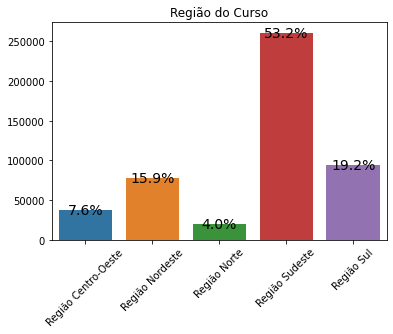

In [36]:
# Plotando variável Região do Curso
total = float(len(df_2021["CO_REGIAO_CURSO"]))
ax=sns.countplot(df_2021["CO_REGIAO_CURSO"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() /2
    y = p.get_height()
    ax.annotate(percentage, (x, y),size=14,ha="center",va="center")
plt.xticks(rotation=45)
plt.title("Região do Curso")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Unidade da Federação do Curso

In [37]:
df_2021["CO_UF_CURSO"].map(mapear_coluna(df_2021,data_dict_2021, "CO_UF_CURSO")).unique()

array(['MATO GROSSO (MT)', 'DISTRITO FEDERAL (DF)', 'SERGIPE (SE)',
       'AMAZONAS (AM)', 'PIAUÍ (PI)', 'MINAS GERAIS (MG)',
       'SÃO PAULO (SP)', 'PARANÁ (PR)', 'PERNAMBUCO (PE)',
       'RIO GRANDE DO SUL (RS)', 'RIO DE JANEIRO (RJ)', 'BAHIA (BA)',
       'CEARÁ (CE)', 'SANTA CATARINA (SC)', 'GOIÁS (GO)',
       'RIO GRANDE DO NORTE (RN)', 'PARÁ (PA)', 'MATO GROSSO DO SUL (MS)',
       'RONDÔNIA (RO)', 'TOCANTINS (TO)', 'ALAGOAS (AL)', 'MARANHÃO (MA)',
       'ACRE (AC)', 'PARAÍBA (PB)', 'ESPÍRITO SANTO (ES)', 'RORAIMA (RR)',
       'AMAPA (AP)'], dtype=object)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


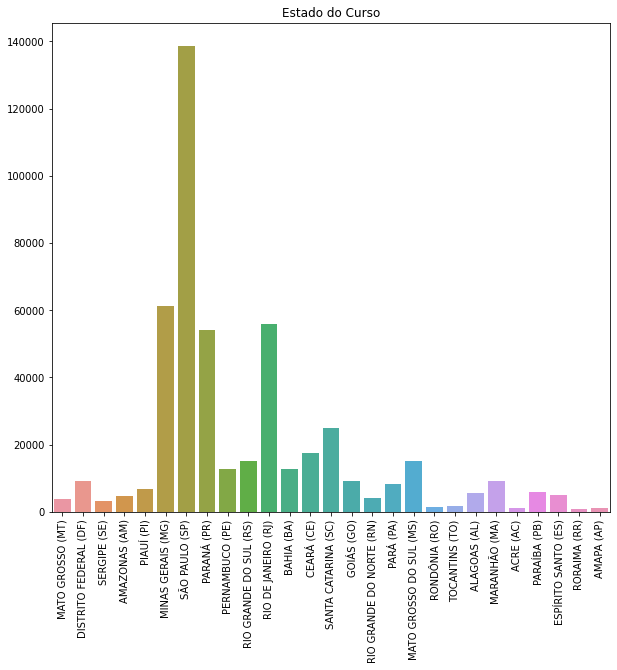

In [38]:
# Plotando variável Unidade da Federação do Curso
fig = plt.figure(figsize=(10, 9))
sns.countplot(df_2021["CO_UF_CURSO"].map(mapear_coluna(df_2021, data_dict_2021, "CO_UF_CURSO")))
plt.xticks(rotation=90)
plt.title("Estado do Curso")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Idade

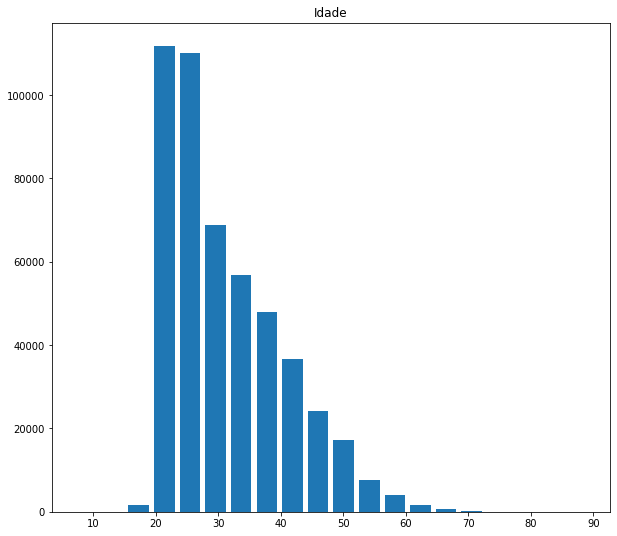

In [39]:
# Plotando a variável idade
fig = plt.figure(figsize=(10, 9))
plt.hist(df_2021["NU_IDADE"],bins=20,histtype="bar",rwidth=.8)
plt.title("Idade")
plt.show()

# Sexo

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


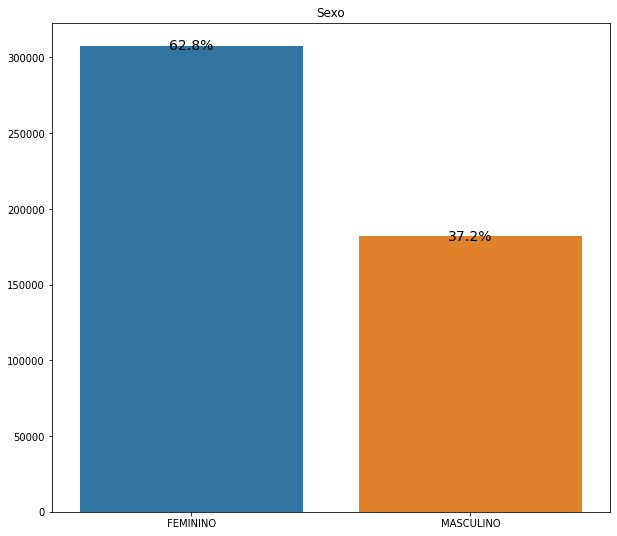

In [40]:
# Plotando a variável sexo
fig = plt.figure(figsize=(10, 9))
total = float(len(df_2021["TP_SEXO"]))
ax=sns.countplot(df_2021["TP_SEXO"].map(mapear_coluna(df_2021, data_dict_2021, 'TP_SEXO')))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() /2
    y = p.get_height()
    ax.annotate(percentage, (x, y),size=14,ha="center",va="center")
plt.title("Sexo")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Estado Civil

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


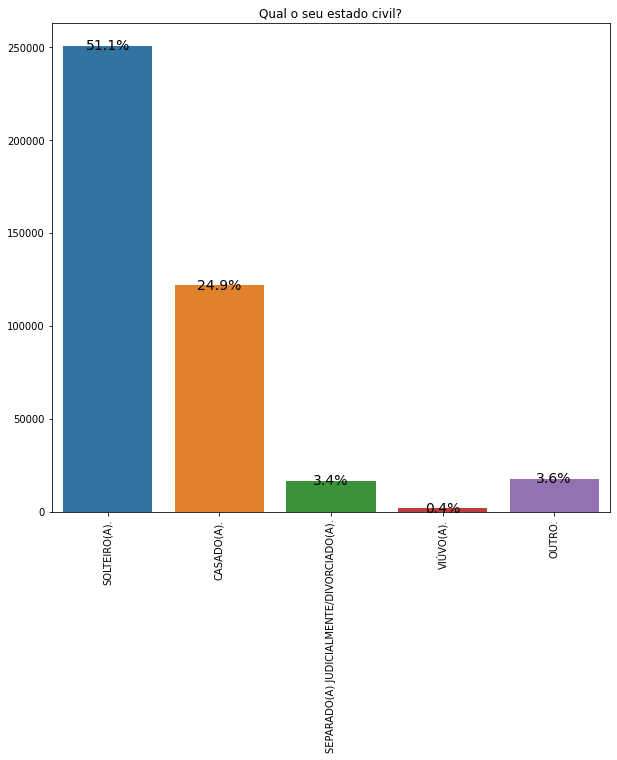

In [41]:
# Plotando a variável estado civil
fig = plt.figure(figsize=(10, 9))
total = float(len(df_2021["QE_I01"]))
ax=sns.countplot(df_2021["QE_I01"].map(mapear_coluna(df_2021, data_dict_2021, 'QE_I01')))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() /2
    y = p.get_height()
    ax.annotate(percentage, (x, y),size=14,ha="center",va="center")
plt.xticks(rotation=90)
plt.title("Qual o seu estado civil?")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Cor/Raça

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


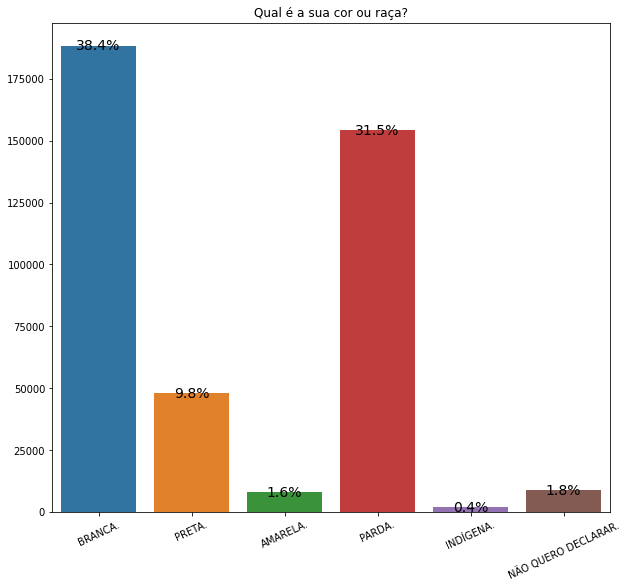

In [42]:
# Plotando a variável cor/raça
fig = plt.figure(figsize=(10, 9))
total = float(len(df_2021["QE_I02"]))
ax=sns.countplot(df_2021["QE_I02"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I02")))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() /2
    y = p.get_height()
    ax.annotate(percentage, (x, y),size=14,ha="center",va="center")
plt.xticks(rotation=25)
plt.title("Qual é a sua cor ou raça?")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Instrução do pai

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


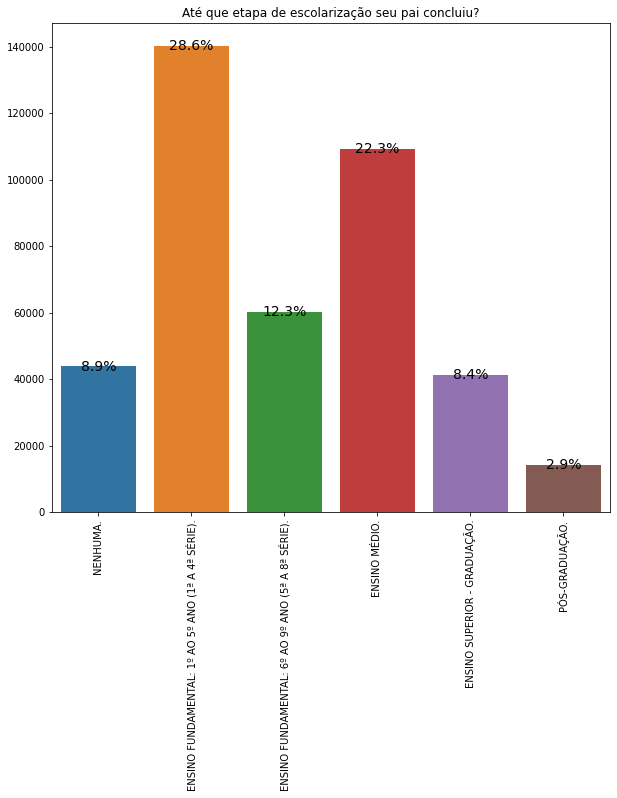

In [43]:
# Plotando a variável instrução do pai
fig = plt.figure(figsize=(10, 9))
total = float(len(df_2021["QE_I04"]))
ax=sns.countplot(df_2021["QE_I04"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I04")))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() /2
    y = p.get_height()
    ax.annotate(percentage, (x, y),size=14,ha="center",va="center")
plt.xticks(rotation=90)
plt.title("Até que etapa de escolarização seu pai concluiu?")
plt.ylabel("")
plt.xlabel("")
plt.show()

In [44]:
df_2021['QE_I04'].value_counts().T

B    140130
D    109307
C     60256
A     43801
E     41201
F     14288
Name: QE_I04, dtype: int64

In [45]:
labels = df_2021['QE_I04'].map(mapear_coluna(df_2021, data_dict_2021,"QE_I04")).unique()
labels

array(['NENHUMA.', 'ENSINO FUNDAMENTAL: 1º AO 5º ANO (1ª A 4ª SÉRIE).',
       'ENSINO FUNDAMENTAL: 6º AO 9º ANO (5ª A 8ª SÉRIE).',
       'ENSINO MÉDIO.', 'ENSINO SUPERIOR - GRADUAÇÃO.', 'PÓS-GRADUAÇÃO.',
       nan], dtype=object)

In [46]:
df_2021['QE_I04']

0           A
1           A
2           A
3           A
4           A
         ... 
489861    NaN
489862    NaN
489863    NaN
489864    NaN
489865    NaN
Name: QE_I04, Length: 489866, dtype: object

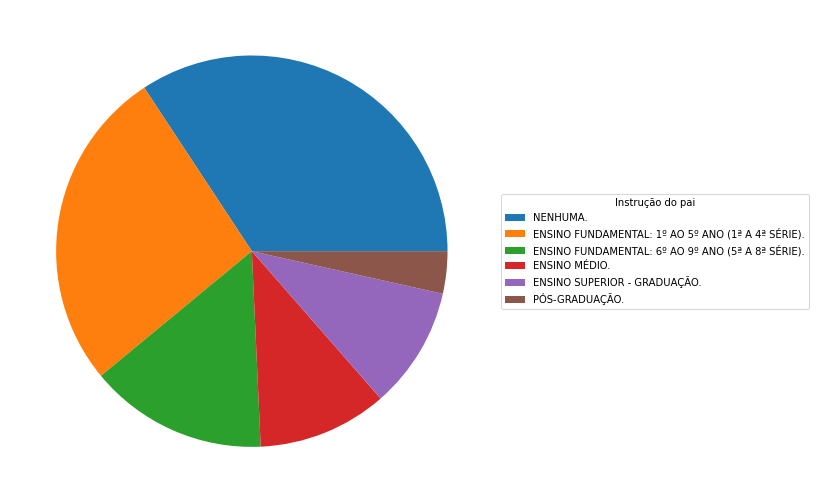

In [47]:
# Estamos criando a representação, área de plotagem

labels = df_2021['QE_I04'].map(mapear_coluna(df_2021, data_dict_2021,"QE_I04")).unique()

# Criando o gráfico
fig = plt.figure(figsize=(10, 9))

# Criando o gráfico e colocando a função da legenda interna
plt.pie(df_2021['QE_I04'].value_counts().T,)

plt.legend(labels,
          title="Instrução do pai",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Mostra o gráfico
plt.show()

# RELACIONANDO NOTA COM DEMAIS VARIÁVEIS

In [48]:
# Estabelendo parâmetros outliers e mean
flierprops = dict(marker='o', markerfacecolor='grey', markersize=8,
                  linestyle='none')
meanprops = dict(marker='o', markerfacecolor='white', markersize=12,
                 markeredgecolor='red')

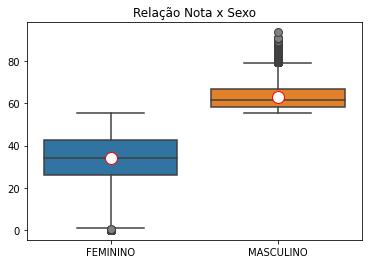

In [49]:
# Plotando relação entre nota x sexo
sns.boxplot(y="NT_GER",x = df_2021["TP_SEXO"].map(mapear_coluna(df_2021, data_dict_2021,"TP_SEXO")),data = df_2021,showmeans=True,
            meanprops=meanprops,flierprops=flierprops)
plt.title("Relação Nota x Sexo")
plt.ylabel("")
plt.xlabel("")
plt.show()

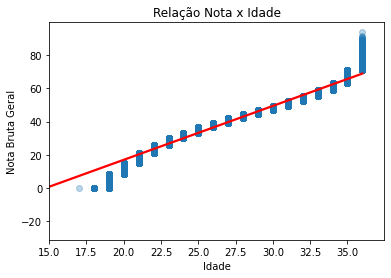

In [50]:
# Plotando relação entre nota x idade
sns.regplot(y="NT_GER", x="NU_IDADE", data=df_2021,line_kws={"color": "red"},scatter_kws={'alpha':0.3})
plt.title("Relação Nota x Idade")
plt.xlabel("Idade")
plt.ylabel("Nota Bruta Geral")
plt.xlim(15)
plt.show()

# Relação entre nota e Região do Curso

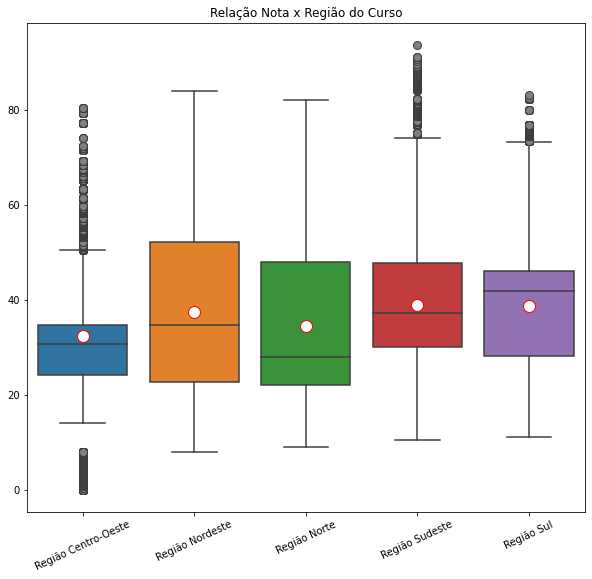

In [51]:
# Plotando relação entre nota x região do curso

# Criando o gráfico
fig = plt.figure(figsize=(10, 9))
sns.boxplot(y="NT_GER",x="CO_REGIAO_CURSO",data=df_2021,showmeans=True,
            meanprops=meanprops,flierprops=flierprops)
plt.title("Relação Nota x Região do Curso")
plt.xticks(rotation=25)
plt.ylabel("")
plt.xlabel("")
plt.show()

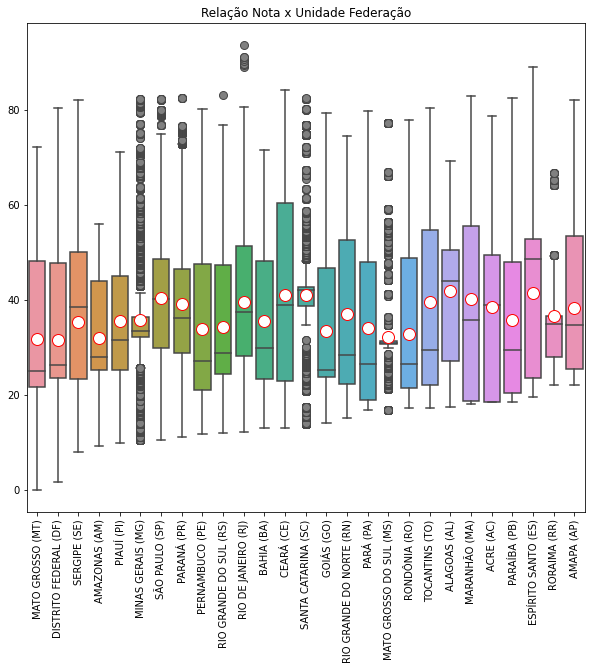

In [52]:
# Plotando relação entre nota x UF de funcionamento do curso
fig = plt.figure(figsize=(10, 9))
sns.boxplot(y="NT_GER",x= df_2021["CO_UF_CURSO"].map(mapear_coluna(df_2021, data_dict_2021,"CO_UF_CURSO")),data=df_2021,showmeans=True,
            meanprops=meanprops,flierprops=flierprops)
plt.title("Relação Nota x Unidade Federação")
plt.xticks(rotation=90)
plt.ylabel("")
plt.xlabel("")
plt.show()

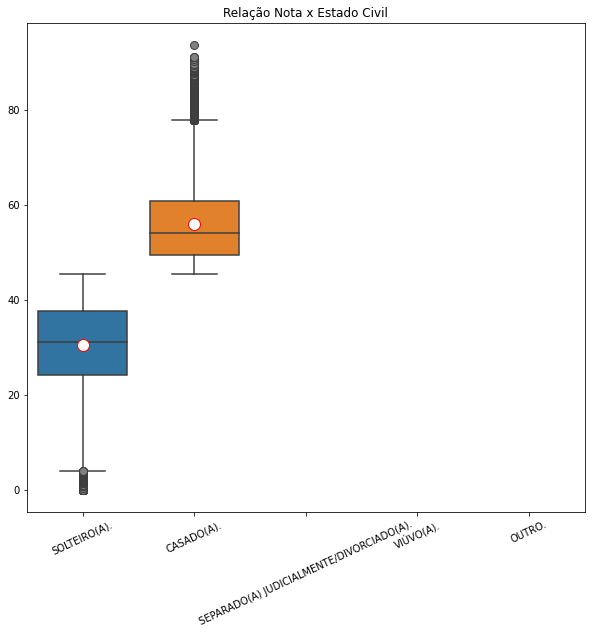

In [53]:
# Plotando relação entre nota x estado civil
fig = plt.figure(figsize=(10, 9))
sns.boxplot(y="NT_GER",x= df_2021["QE_I01"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I01")),data = df_2021,showmeans=True,
            meanprops = meanprops,flierprops=flierprops)
plt.title("Relação Nota x Estado Civil")
plt.xticks(rotation=25)
plt.ylabel("")
plt.xlabel("")
plt.show()

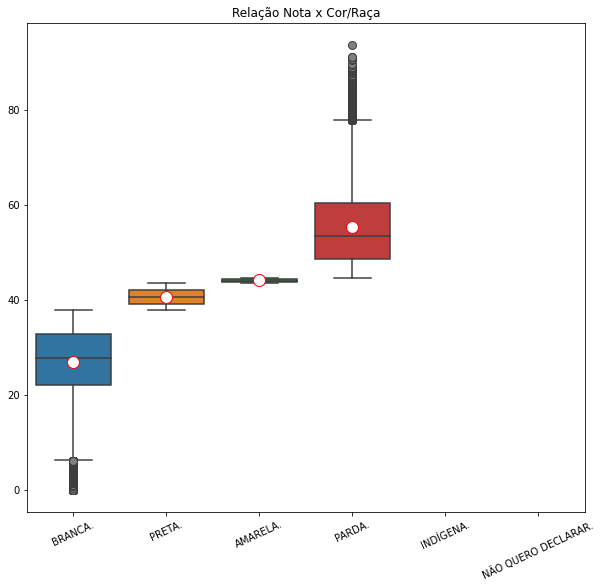

In [54]:
# Plotando relação entre nota x cor/raça
fig = plt.figure(figsize=(10, 9))
sns.boxplot(y="NT_GER",x= df_2021["QE_I02"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I02")),data=df_2021,showmeans=True,
            meanprops=meanprops,flierprops=flierprops)
plt.title("Relação Nota x Cor/Raça")
plt.xticks(rotation=25)
plt.ylabel("")
plt.xlabel("")
plt.show()

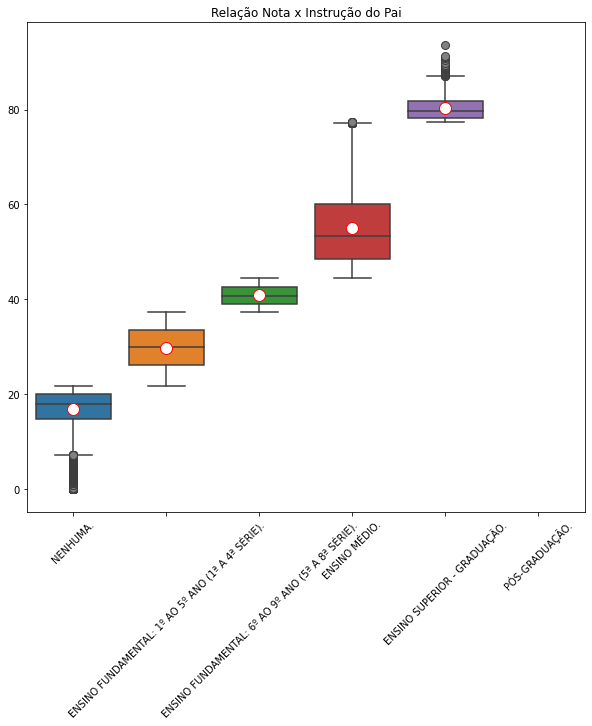

In [55]:
# Plotando relação entre nota x instrução do pai
fig = plt.figure(figsize=(10, 9))
sns.boxplot(y="NT_GER",x= df_2021["QE_I04"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I04")),data=df_2021,showmeans=True,
            meanprops=meanprops,flierprops=flierprops)
plt.title("Relação Nota x Instrução do Pai")
plt.xticks(rotation=45)
plt.ylabel("")
plt.xlabel("")
plt.show()

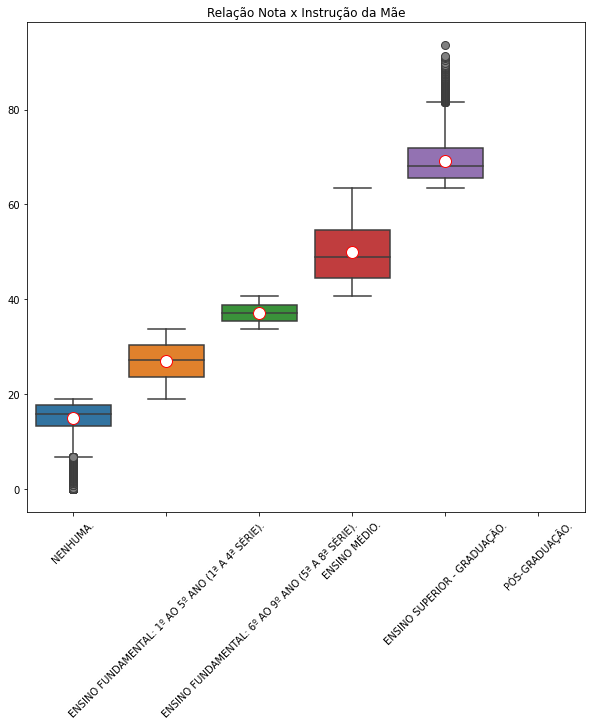

In [56]:
# Plotando relação entre nota x instrução da mãe
fig = plt.figure(figsize=(10, 9))
sns.boxplot(y="NT_GER",x= df_2021["QE_I05"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I05")),data= df_2021,showmeans=True,
            meanprops=meanprops,flierprops=flierprops)
plt.title("Relação Nota x Instrução da Mãe")
plt.xticks(rotation=45)
plt.ylabel("")
plt.xlabel("")
plt.show()

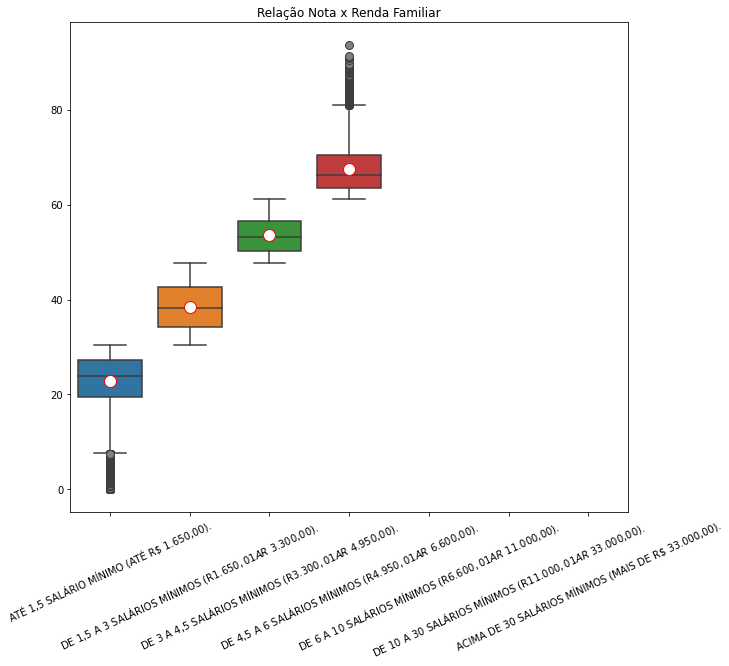

In [57]:
# Plotando relação entre nota x renda familiar
fig = plt.figure(figsize=(10, 9))
sns.boxplot(y="NT_GER",x= df_2021["QE_I08"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I08")),data=df_2021,showmeans=True,
            meanprops=meanprops,flierprops=flierprops)
plt.title("Relação Nota x Renda Familiar")
plt.xticks(rotation=25)
plt.ylabel("")
plt.xlabel("")
plt.show()

# Estado de Goiás

Filtrando os dados e criando um dataframe para trabalharmos

In [58]:
# filter dataframe                                   
filtered_values = np.where(df_2021['CO_UF_CURSO']== 52)
print(filtered_values)
display(df_2021.loc[filtered_values])

(array([  8474,   8475,   8476, ..., 489802, 489803, 489804]),)


,NU_ANO,CO_CURSO,TP_SEXO,NU_ANO,CO_CURSO,QE_I08,NU_ANO,CO_CURSO,QE_I21,NU_ANO,...,NU_ANO,CO_CURSO,QE_I74,NU_ANO,CO_CURSO,QE_I14,NU_ANO,CO_CURSO,QE_I22,QE_RESPOSTAS_IGUAIS
8474,2021,79377,F,2021,121222,A,2021,1047529,A,2021,...,2021,11889,A,2021,87280,A,2021,1382712,A,True
8475,2021,79377,F,2021,1420353,A,2021,1159666,A,2021,...,2021,66671,A,2021,87280,A,2021,1296649,A,True
8476,2021,79377,F,2021,113025,A,2021,1137223,A,2021,...,2021,85058,A,2021,87280,A,2021,1181231,A,True
8477,2021,79377,F,2021,103338,A,2021,5001328,A,2021,...,2021,79377,A,2021,87280,A,2021,102166,A,True
8478,2021,79377,F,2021,89380,A,2021,5001328,A,2021,...,2021,79377,A,2021,87280,A,2021,111270,A,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489800,2021,1052090,NaN,2021,1214744,NaN,2021,1214744,NaN,2021,...,2021,1214744,NaN,2021,1214744,NaN,2021,1214744,NaN,False
489801,2021,48044,NaN,2021,20257,NaN,2021,20257,NaN,2021,...,2021,1214744,NaN,2021,20257,NaN,2021,20257,NaN,False
489802,2021,39060,NaN,2021,1214744,NaN,2021,1214744,NaN,2021,...,2021,1214744,NaN,2021,1214744,NaN,2021,1214744,NaN,False
489803,2021,1365445,NaN,2021,1214744,NaN,2021,1214744,NaN,2021,...,2021,1214744,NaN,2021,1214744,NaN,2021,1214744,NaN,False


In [59]:
df_2021.loc[filtered_values]["QE_I08"]

8474        A
8475        A
8476        A
8477        A
8478        A
         ... 
489800    NaN
489801    NaN
489802    NaN
489803    NaN
489804    NaN
Name: QE_I08, Length: 9320, dtype: object

# Categoria  categoria Administrativa da IES - Estado de Goiás

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


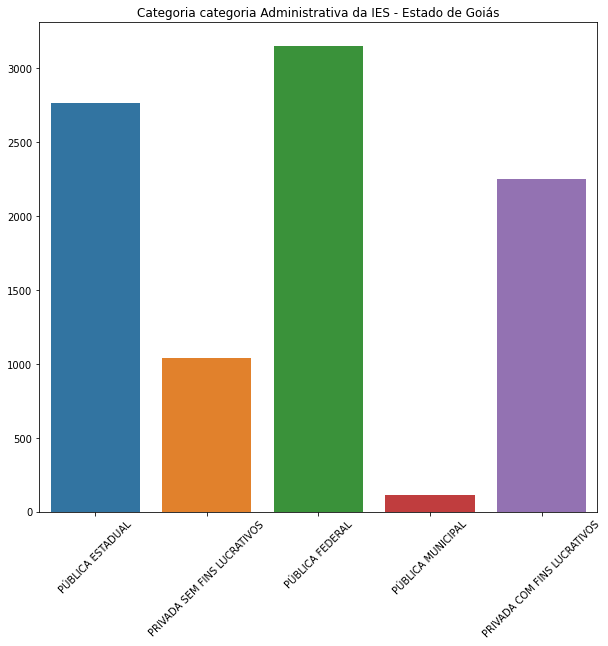

In [60]:
# Plotando variável Categoria  categoria Administrativa da IES - Estado de Goiás
fig = plt.figure(figsize=(10, 9))
sns.countplot(df_2021.loc[filtered_values]["CO_CATEGAD"].map(mapear_coluna(df_2021, data_dict_2021, "CO_CATEGAD")))

plt.xticks(rotation=45)
plt.title("Categoria categoria Administrativa da IES - Estado de Goiás")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Idade

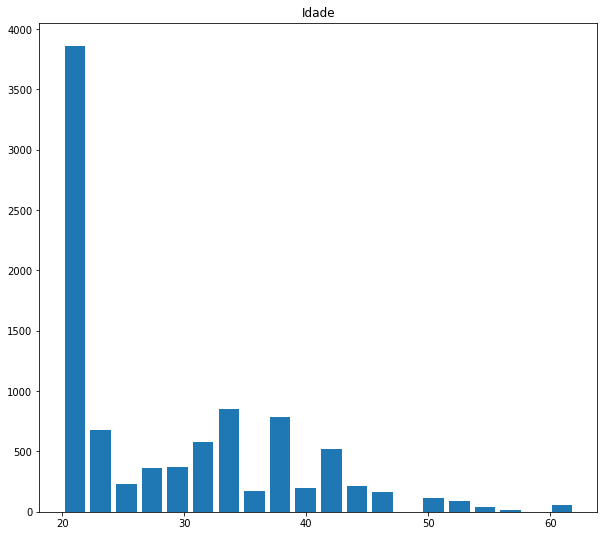

In [61]:
# Plotando a variável idade
fig = plt.figure(figsize=(10, 9))
plt.hist(df_2021.loc[filtered_values]["NU_IDADE"],bins=20,histtype="bar",rwidth=.8)
plt.title("Idade")
plt.show()

# Sexo

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


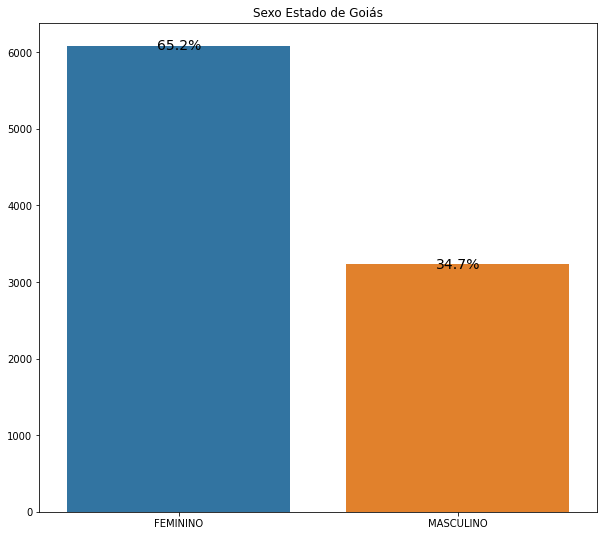

In [62]:
# Plotando a variável sexo
fig = plt.figure(figsize=(10, 9))
total = float(len(df_2021.loc[filtered_values]["TP_SEXO"]))
ax=sns.countplot(df_2021.loc[filtered_values]["TP_SEXO"].map(mapear_coluna(df_2021, data_dict_2021, 'TP_SEXO')))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() /2
    y = p.get_height()
    ax.annotate(percentage, (x, y),size=14,ha="center",va="center")
plt.title("Sexo Estado de Goiás")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Estado Civil

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


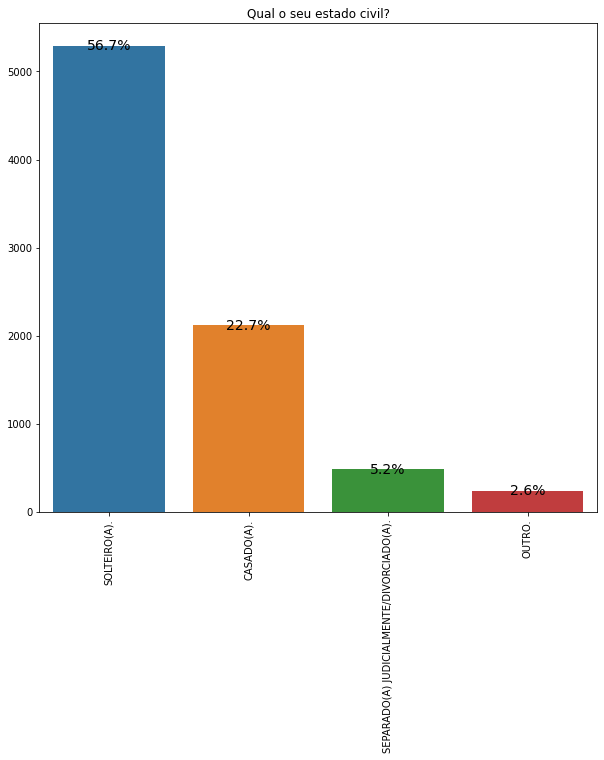

In [63]:
# Plotando a variável estado civil no Estado de Goiás
fig = plt.figure(figsize=(10, 9))
total = float(len(df_2021.loc[filtered_values]["QE_I01"]))
ax=sns.countplot(df_2021.loc[filtered_values]["QE_I01"].map(mapear_coluna(df_2021, data_dict_2021, 'QE_I01')))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() /2
    y = p.get_height()
    ax.annotate(percentage, (x, y),size=14,ha="center",va="center")
plt.xticks(rotation=90)
plt.title("Qual o seu estado civil?")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Renda Familiar

In [64]:
labels = df_2021.loc[filtered_values]['QE_I08'].map(mapear_coluna(df_2021, data_dict_2021,"QE_I08")).unique()
labels

array(['ATÉ 1,5 SALÁRIO MÍNIMO (ATÉ R$ 1.650,00).',
       'DE 1,5 A 3 SALÁRIOS MÍNIMOS (R$ 1.650,01 A R$ 3.300,00).',
       'DE 3 A 4,5 SALÁRIOS MÍNIMOS (R$ 3.300,01 A R$ 4.950,00).',
       'DE 4,5 A 6 SALÁRIOS MÍNIMOS (R$ 4.950,01 A R$ 6.600,00).',
       'DE 6 A 10 SALÁRIOS MÍNIMOS (R$ 6.600,01 A R$ 11.000,00).',
       'DE 10 A 30 SALÁRIOS MÍNIMOS (R$ 11.000,01 A R$ 33.000,00).',
       'ACIMA DE 30 SALÁRIOS MÍNIMOS (MAIS DE R$ 33.000,00).', nan],
      dtype=object)

<AxesSubplot:ylabel='QE_I08'>

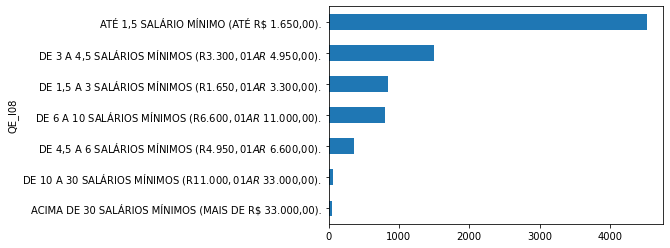

In [65]:
# Plotando a variável cor/raça
   
df_2021.loc[filtered_values].groupby(df_2021.loc[filtered_values]["QE_I08"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I08"))).QE_I08.count().sort_values().plot(kind='barh')


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


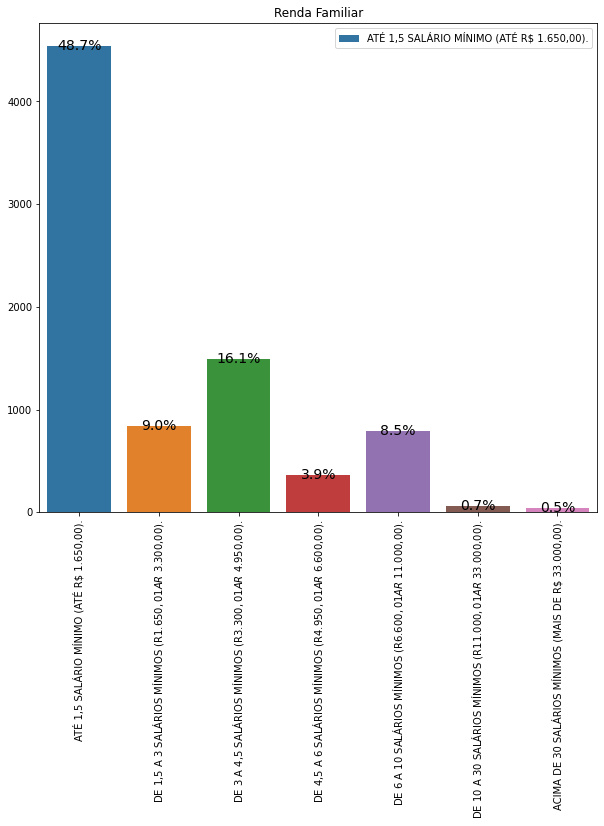

In [66]:
# Plotando a variável renda familiar no Estado de Goiás
labels = df_2021['QE_I08'].map(mapear_coluna(df_2021, data_dict_2021,"QE_I08"))

fig = plt.figure(figsize=(10, 9))
total = float(len(df_2021.loc[filtered_values]["QE_I08"]))
ax = sns.countplot(df_2021.loc[filtered_values]["QE_I08"].map(mapear_coluna(df_2021, data_dict_2021, 'QE_I08')))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() /2
    y = p.get_height()
    ax.annotate(percentage, (x, y),size=14,ha="center",va="center")
     
    plt.legend(labels)
   
plt.xticks(rotation=90)
plt.title("Renda Familiar")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Cor Raça

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


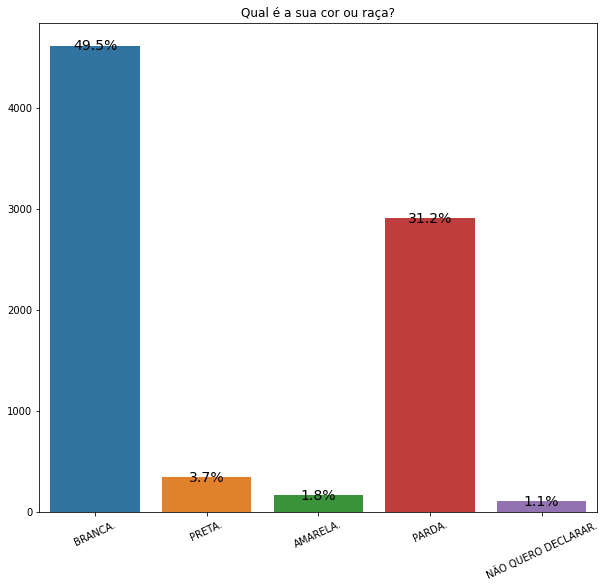

In [67]:
# Plotando a variável cor/raça
fig = plt.figure(figsize=(10, 9))
total = float(len(df_2021.loc[filtered_values]["QE_I02"]))
ax=sns.countplot(df_2021.loc[filtered_values]["QE_I02"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I02")))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() /2
    y = p.get_height()
    ax.annotate(percentage, (x, y),size=14,ha="center",va="center")
plt.xticks(rotation=25)
plt.title("Qual é a sua cor ou raça?")
plt.ylabel("")
plt.xlabel("")
plt.show()

<AxesSubplot:xlabel='QE_I02'>

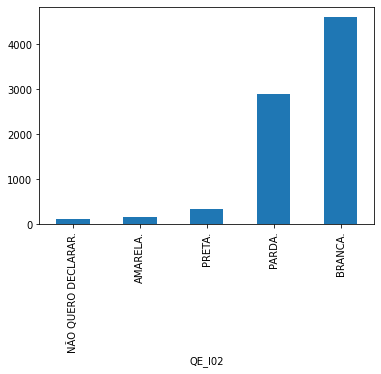

In [68]:
# Plotando a variável cor/raça
   
df_2021.loc[filtered_values].groupby(df_2021.loc[filtered_values]["QE_I02"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I02"))).QE_I02.count().sort_values().plot(kind='bar')


# Relação entre nota x renda familiar

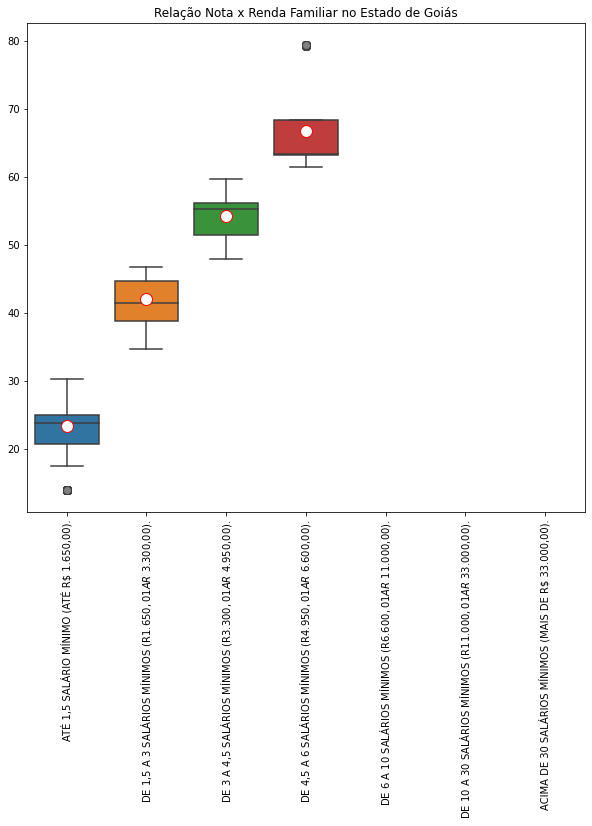

In [69]:
# Plotando relação entre nota x renda familiar
fig = plt.figure(figsize=(10, 9))
sns.boxplot(y="NT_GER",x= df_2021.loc[filtered_values]["QE_I08"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I08")),data=df_2021.loc[filtered_values],showmeans=True,
            meanprops=meanprops,flierprops=flierprops)
plt.title("Relação Nota x Renda Familiar no Estado de Goiás")
plt.xticks(rotation=90)
plt.ylabel("")
plt.xlabel("")
plt.show()

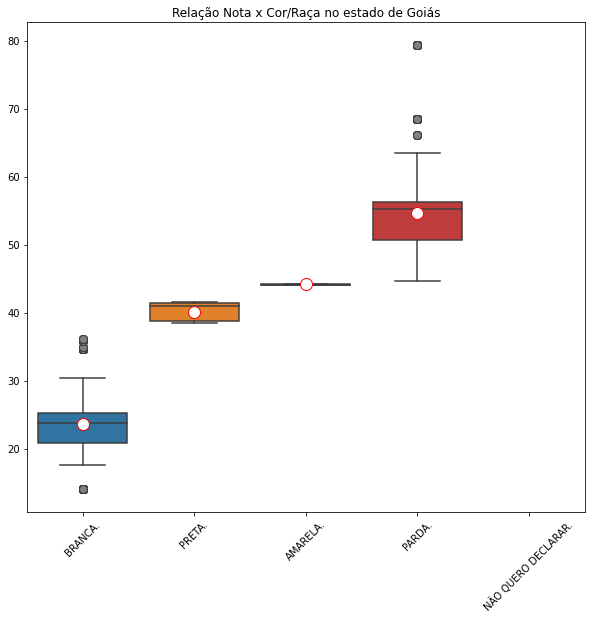

In [70]:
# Plotando relação entre nota x cor/raça no estado de Goiás
fig = plt.figure(figsize=(10, 9))
sns.boxplot(y="NT_GER",x= df_2021.loc[filtered_values]["QE_I02"].map(mapear_coluna(df_2021, data_dict_2021,"QE_I02")),data=df_2021.loc[filtered_values],showmeans=True,
            meanprops=meanprops,flierprops=flierprops)
plt.title("Relação Nota x Cor/Raça no estado de Goiás")
plt.xticks(rotation=45)
plt.ylabel("")
plt.xlabel("")
plt.show()